In [20]:
import zipfile
import os

zip_file_path = 'mini-project-1.zip'
extract_to = 'extracted files'

if not os.path.exists(extract_to) :
    os.makedirs(extract_to)

with zipfile.ZipFile(zip_file_path , 'r') as zip_ref :
    zip_ref.extractall(extract_to)

FileNotFoundError: [Errno 2] No such file or directory: 'mini-project-1.zip'

In [21]:
import pandas as pd
import numpy as np

# read emoticon dataset
train_emoticon_df = pd.read_csv("datasets/train/train_emoticon.csv")
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()
train_emoticon_Y = train_emoticon_df['label'].tolist()

valid_emoticon_df = pd.read_csv("datasets/valid/valid_emoticon.csv")
valid_emoticon_X = valid_emoticon_df['input_emoticon'].tolist()
valid_emoticon_Y = valid_emoticon_df['label'].tolist()

test_emoticon_X = pd.read_csv("datasets/test/test_emoticon.csv")['input_emoticon'].tolist()

# read text sequence dataset
train_seq_df = pd.read_csv("datasets/train/train_text_seq.csv")
train_seq_X = train_seq_df['input_str'].tolist()
train_seq_Y = train_seq_df['label'].tolist()

test_seq_X = pd.read_csv("datasets/test/test_text_seq.csv")['input_str'].tolist()



# read feature dataset
train_feat = np.load("datasets/train/train_feature.npz", allow_pickle=True)
train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']

test_feat_X = np.load("datasets/test/test_feature.npz", allow_pickle=True)['features']


print(f"Train dataset size: ")
print(f"train_emoticon_X: {len(train_emoticon_X)} train_emoticon_Y: {len(train_emoticon_Y)}")
print(f"train_seq_X: {len(train_seq_X)} train_seq_Y: {len(train_seq_Y)}")
print(f"train_feat_X: {train_feat_X.shape} train_feat_Y: {train_feat_Y.shape}")


print()
print("Test dataset size: ")
print(f"test_emoticon_X: {len(test_emoticon_X)}")
print(f"test_seq_X: {len(test_seq_X)} ")
print(f"test_feat_X: {test_feat_X.shape}")

Train dataset size: 
train_emoticon_X: 7080 train_emoticon_Y: 7080
train_seq_X: 7080 train_seq_Y: 7080
train_feat_X: (7080, 13, 768) train_feat_Y: (7080,)

Test dataset size: 
test_emoticon_X: 2232
test_seq_X: 2232 
test_feat_X: (2232, 13, 768)


In [22]:
from sentence_transformers import SentenceTransformer
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

y_train = np.array(train_emoticon_Y)

Evaluating model: all-MiniLM-L6-v2
Accuracy with 20% training data: 0.48
Accuracy with 40% training data: 0.52
Accuracy with 60% training data: 0.48
Accuracy with 80% training data: 0.48
Accuracy with 100% training data: 0.48


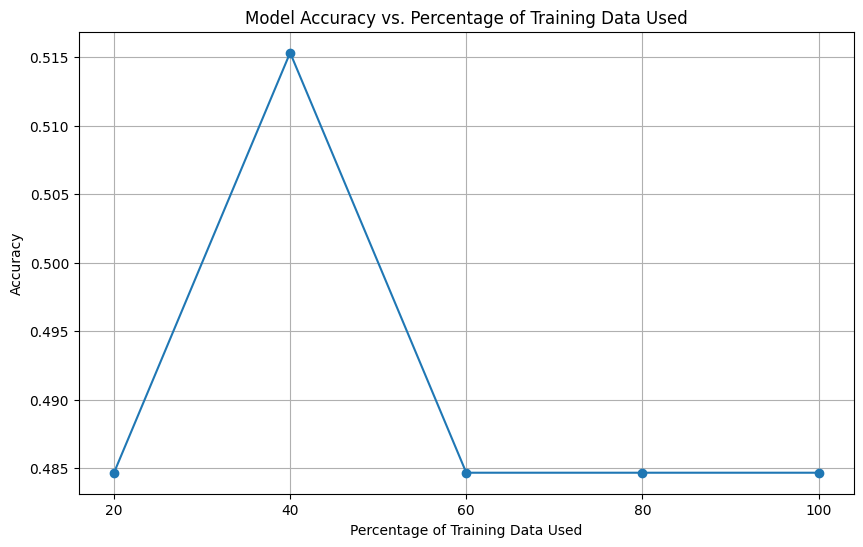

Evaluating model: distilbert-base-nli-stsb-mean-tokens
Accuracy with 20% training data: 0.48
Accuracy with 40% training data: 0.52
Accuracy with 60% training data: 0.48
Accuracy with 80% training data: 0.48
Accuracy with 100% training data: 0.48


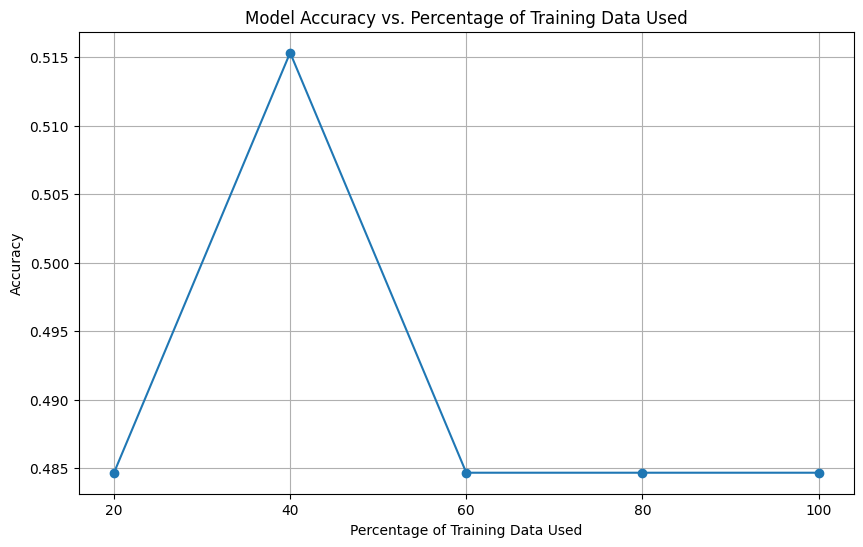

Evaluating model: roberta-base-nli-stsb-mean-tokens
Accuracy with 20% training data: 0.50
Accuracy with 40% training data: 0.47
Accuracy with 60% training data: 0.51
Accuracy with 80% training data: 0.49


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []

models_to_test = [
    'all-MiniLM-L6-v2',
    'distilbert-base-nli-stsb-mean-tokens',
    'roberta-base-nli-stsb-mean-tokens',
    'bert-base-nli-mean-tokens'
]

results = {}

for model_name in models_to_test :
    print(f"Evaluating model: {model_name}")
    model = SentenceTransformer(model_name)
    accuracies = []

    for percentage in percentages:
        # Calculate the number of samples to take
        n_samples = int(len(train_emoticon_X) * percentage)
    
        # Create subsets of training data
        x_train_subset = train_emoticon_X[:n_samples]
        y_train_subset = train_emoticon_Y[:n_samples]
    
        # Generate embeddings for the training subset
        x_train_embeddings = model.encode(x_train_subset)
        x_val_embeddings = model.encode(valid_emoticon_X)

        # Calculate class prototypes
        class_prototypes = [
            np.mean(x_train_embeddings[np.array(y_train_subset) == 0], axis=0),
            np.mean(x_train_embeddings[np.array(y_train_subset) == 1], axis=0)
        ]
    
        # Predict labels for the validation set
        predicted_labels = [0 if np.argmin(np.linalg.norm(sample - class_prototypes, axis=1)) == 0 else 1 for sample in x_val_embeddings]
    
        # Calculate accuracy
        accuracy = accuracy_score(y_val, predicted_labels)
        accuracies.append(accuracy)
        print(f"Accuracy with {percentage * 100:.0f}% training data: {accuracy:.2f}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot([p * 100 for p in percentages], accuracies, marker='o')
    plt.title("Model Accuracy vs. Percentage of Training Data Used")
    plt.xlabel("Percentage of Training Data Used")
    plt.ylabel("Accuracy")
    plt.xticks([20, 40, 60, 80, 100])
    plt.grid()
    plt.show()